<a href="https://colab.research.google.com/github/ericdnbn/nn_image_classifier_pneumonia/blob/main/Copy2_of_Eric%E2%80%93nn_classifier_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test/' 

In [3]:
!find . -name ".DS_Store" -delete

In [4]:
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneu_dir = os.path.join(test_dir, 'PNEUMONIA')

val_normal_dir = os.path.join(val_dir, 'NORMAL')
val_pneu_dir = os.path.join(val_dir, 'PNEUMONIA')

In [5]:
train_normal_dir

'chest_xray/train/NORMAL'

In [6]:
len(os.listdir(train_normal_dir))

1349

In [7]:
# get all the data in the directory split/train (542 images), and reshape them
arg_dict = {'target_size':(256, 256), 
            'color_mode':'grayscale', 
            'batch_size':50}

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='training')


# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict) 


# get all the data in the directory split/validation (200 images), and reshape them
val_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='validation')


Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [8]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [9]:
train_images[0]

array([[[0.00784314],
        [0.00784314],
        [0.00784314],
        ...,
        [0.03137255],
        [0.00392157],
        [0.03921569]],

       [[0.00784314],
        [0.00784314],
        [0.00784314],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.00784314],
        [0.00784314],
        [0.00784314],
        ...,
        [0.01568628],
        [0.02745098],
        [0.01568628]],

       ...,

       [[0.00392157],
        [0.00392157],
        [0.00392157],
        ...,
        [0.00392157],
        [0.00392157],
        [0.00392157]],

       [[0.00392157],
        [0.00392157],
        [0.00392157],
        ...,
        [0.00392157],
        [0.00392157],
        [0.00392157]],

       [[0.00392157],
        [0.00392157],
        [0.00392157],
        ...,
        [0.00392157],
        [0.00392157],
        [0.00392157]]], dtype=float32)

In [10]:
train_images.shape[0]

50

In [11]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 50
Number of testing samples: 50
Number of validation samples: 50
train_images shape: (50, 256, 256, 1)
train_labels shape: (50, 2)
test_images shape: (50, 256, 256, 1)
test_labels shape: (50, 2)
val_images shape: (50, 256, 256, 1)
val_labels shape: (50, 2)


In [12]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(50, 65536)
(50, 65536)
(50, 65536)


In [13]:
train_y = np.reshape(train_labels[:,0], (train_images.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_images.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_images.shape[0],1))

print(train_y)
print(test_y)
print(val_y)

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]
[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]


In [16]:
# First Simple Model
model = models.Sequential()

In [17]:
model.add(layers.Dense(32, activation='relu', input_shape=(65536,)))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [19]:
history = model.fit(train_img, 
                    train_y,
                    epochs=50,
                    batch_size=10,
                    validation_data=(val_img, val_y))

Epoch 1/50
5/5 [==============================] - 1s 85ms/step - loss: 3.6826 - accuracy: 0.5000 - recall: 0.3889 - val_loss: 0.5283 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6980 - accuracy: 0.6000 - recall: 0.3889 - val_loss: 0.6932 - val_accuracy: 0.3400 - val_recall: 0.8333
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6902 - accuracy: 0.6400 - recall: 0.8333 - val_loss: 0.6795 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6826 - accuracy: 0.6400 - recall: 0.0000e+00 - val_loss: 0.6522 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6681 - accuracy: 0.6400 - recall: 0.0000e+00 - val_loss: 0.5995 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6635 - accuracy: 0

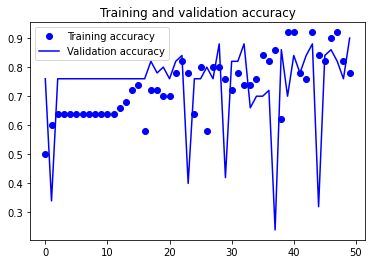

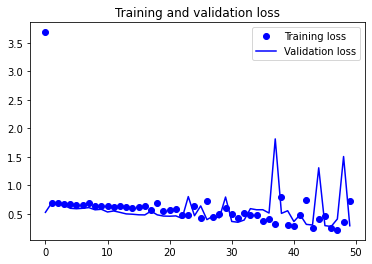

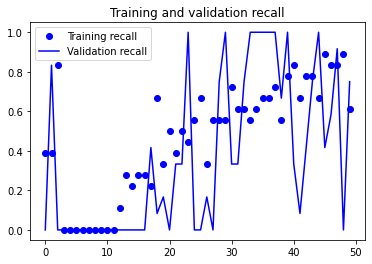

In [20]:

import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

In [21]:
results_train = model.evaluate(train_img, train_y)

2/2 [==============================] - 0s 8ms/step - loss: 0.1973 - accuracy: 0.9800 - recall: 0.9444


In [22]:
results_train

[0.19728876650333405, 0.9800000190734863, 0.9444444179534912]

In [23]:
results_test = model.evaluate(test_img, test_y)

2/2 [==============================] - 0s 9ms/step - loss: 0.2955 - accuracy: 0.8600 - recall: 0.6471


In [24]:
results_test

[0.2955414652824402, 0.8600000143051147, 0.6470588445663452]

In [26]:
preds = (model.predict(train_img) > 0.5).astype('int32')

cm = confusion_matrix(train_y, preds)

In [27]:
cm

array([[32,  0],
       [ 1, 17]])

In [28]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Nomral', 'Pneumonia'])

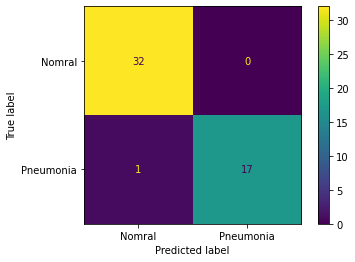

In [29]:
cmd.plot()

In [97]:
from sklearn.utils import class_weight

# Calculate floats/raw class weights
def get_class_weights():

    class_weights = class_weight.compute_class_weight(
                   'balanced',
                    np.unique(train_generator.classes), 
                    train_generator.classes)

# Convert to dict for .fit(class_weight= ) param
    nn_class_weights = {0:class_weights[0], 1:class_weights[1]}
    
    return nn_class_weights

In [15]:
def preprocessing_dense_data(train_directory=train_dir,
                             test_directory=test_dir,
                             ts_tuple=(256,256), 
                             color='grayscale', 
                             batch_size=None,
                             process_test=False):

    
    arg_dict = {'target_size':ts_tuple, 
                'color_mode':color, 
                'batch_size':batch_size}

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
       
    train_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='training') 

    val_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='validation')
    
    
    train_images, train_labels = next(train_generator)
    
    val_images, val_labels = next(val_generator)
    
    
    X_train = train_images.reshape(train_images.shape[0], -1)
    
    X_val = val_images.reshape(val_images.shape[0], -1)
    
    
    y_train = np.reshape(train_labels[:,0], (train_images.shape[0],1))
    
    y_val = np.reshape(val_labels[:,0], (val_images.shape[0],1))
    
    
    return X_train, X_val, y_train, y_val
    
    
    
    
    if process_test:
        
        test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict, subset='test')
        
        test_images, test_labels = next(test_generator)
        
        X_test = test_images.reshape(test_images.shape[0], -1)
        
        y_test = np.reshape(test_labels[:,0], (test_images.shape[0],1))
        
        return X_test, y_test
    
   
    
    


In [31]:
X_train, X_val, y_train, y_val = preprocessing_dense_data(batch_size=200)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [33]:
model2 = models.Sequential()

In [34]:
model2.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [35]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [36]:
history2 = model2.fit(X_train, 
                     y_train,
                     epochs=50,
                     batch_size=10,
                     validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 1s 26ms/step - loss: 1.1244 - accuracy: 0.6800 - recall: 0.2500 - val_loss: 0.5322 - val_accuracy: 0.7650 - val_recall: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 15ms/step - loss: 0.5727 - accuracy: 0.7600 - recall: 0.0000e+00 - val_loss: 0.5150 - val_accuracy: 0.7650 - val_recall: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 0s 15ms/step - loss: 0.5594 - accuracy: 0.7600 - recall: 0.0000e+00 - val_loss: 0.5108 - val_accuracy: 0.7650 - val_recall: 0.0000e+00
Epoch 4/50
20/20 [==============================] - 0s 18ms/step - loss: 0.5253 - accuracy: 0.7600 - recall: 0.0000e+00 - val_loss: 0.5339 - val_accuracy: 0.7650 - val_recall: 0.0000e+00
Epoch 5/50
20/20 [==============================] - 0s 15ms/step - loss: 0.5220 - accuracy: 0.7600 - recall: 0.0000e+00 - val_loss: 0.5649 - val_accuracy: 0.7650 - val_recall: 0.0000e+00
Epoch 6/50
20/20 [==============================] - 0s 15ms/step - lo

In [16]:
def visualize_nn(history, model, X_train, y_train, X_val, y_val):
    acc = history.history['accuracy']
    mean_acc = np.mean(history.history['accuracy'])
    val_acc = history.history['val_accuracy']
    mean_val_acc = np.mean(history.history['val_accuracy'])
    loss = history.history['loss']
    mean_loss = np.mean(history.history['loss'])
    val_loss = history.history['val_loss']
    mean_val_loss = np.mean(history.history['val_loss'])
    recall = history.history['recall']
    mean_recall = np.mean(history.history['recall'])
    val_recall = history.history['val_recall']
    mean_val_recall = np.mean(history.history['val_recall'])

    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()
    plt.show()
    
    
    print(f'Mean Training Accuracy: {mean_acc}')
    print(f'Mean Validation Accuracy: {mean_val_acc}')
    print('')
    print(f'Mean Training Loss: {mean_loss}')
    print(f'Mean Validation Loss: {mean_val_loss}')
    print('')
    print(f'Mean Training Recall: {mean_recall}')
    print(f'Mean Validation Recall: {mean_val_recall}')
    print('')
    print('Training Evaluation:')
    model.evaluate(X_train, y_train)
    print('')
    print('Validation Evaluation:')
    model.evaluate(X_val, y_val)
                                   
    
    
    preds = (model.predict(X_val) > 0.5).astype('int32')
    
    preds2 = (model.predict(X_train) > 0.5).astype('int32')

    cm = confusion_matrix(y_val, preds)
    
    cm2 = confusion_matrix(y_train, preds2)
    
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    
    cmd2 = ConfusionMatrixDisplay(cm2, display_labels=['Normal', 'Pneumonia'])
    
    print('Validation Confusion Matrix:')
    cmd.plot()
    print('')
    cmd2.plot()
    print('Training Confusion Matrix:');

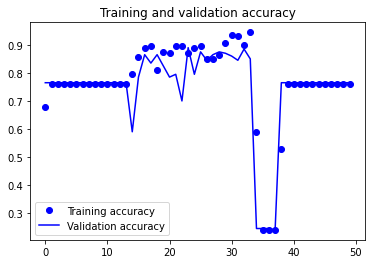

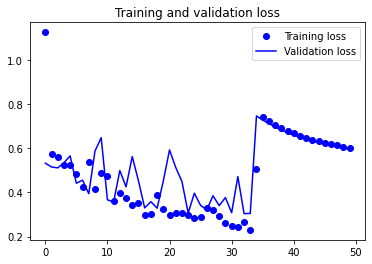

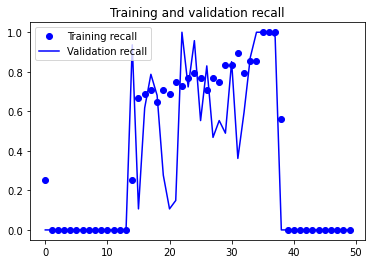

Mean Training Accuracy: 0.7674999931454658
Mean Validation Accuracy: 0.7472999951243401

Mean Training Loss: 0.4715572938323021
Mean Validation Loss: 0.5037172698974609

Mean Training Recall: 0.38541666507720945
Mean Validation Recall: 0.3178723403811455

Training Evaluation:
7/7 [==============================] - 0s 10ms/step - loss: 0.5997 - accuracy: 0.7600 - recall: 0.0000e+00

Validation Evaluation:
7/7 [==============================] - 0s 8ms/step - loss: 0.5959 - accuracy: 0.7650 - recall: 0.0000e+00
Validation Confusion Matrix:

Training Confusion Matrix:


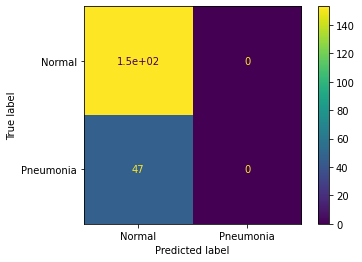

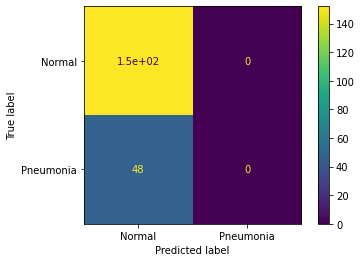

In [38]:
visualize_nn(history2, model2, X_train, y_train, X_val, y_val)

In [17]:
def nn_model(dense_list, 
             input_nodes=64,
             train_directory=train_dir,
             test_directory=test_dir,
             ts_tuple=(256,256), 
             color='grayscale',
             batch_size=1000,
             process_test=False,
             input_activation='relu',
             layer_activation='relu',
             output_activation='sigmoid',
             l2_rate=0.01,
             optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy', 'Recall'],
             epochs=50,
             bs=10):
    
    if not process_test:
        X_train, X_val, y_train, y_val = preprocessing_dense_data(batch_size=batch_size, process_test=process_test)
    
    else:
        X_train, X_test, X_val, y_train, y_test, y_val = preprocessing_dense_data(batch_size=batch_size, process_test=process_test)
    
    
    nn_model = models.Sequential()
    
    
    nn_model.add(layers.Dense(int(input_nodes), activation=input_activation, input_shape=(X_train.shape[1],)))
    
    for i, val in enumerate(dense_list):
        nn_model.add(layers.Dense(int(dense_list[i]), 
                                  activation=layer_activation,
                                  kernel_regularizer=l2(l2=l2_rate)))
        
        
    nn_model.add(layers.Dense(1, activation=output_activation))
        
    nn_model.compile(optimizer=optimizer,
                     loss=loss,
                     metrics=metrics)
    
    
    hist = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_val, y_val))
    
    visualize_nn(hist, nn_model, X_train, y_train, X_val, y_val)
    

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 3s 22ms/step - loss: 1.2113 - accuracy: 0.7100 - recall: 0.0980 - val_loss: 1.3321 - val_accuracy: 0.7440 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 2s 20ms/step - loss: 1.1275 - accuracy: 0.7730 - recall: 0.2314 - val_loss: 1.0251 - val_accuracy: 0.7490 - val_recall: 0.0195
Epoch 3/50
100/100 [==============================] - 2s 20ms/step - loss: 1.0286 - accuracy: 0.7840 - recall: 0.5059 - val_loss: 0.9088 - val_accuracy: 0.8550 - val_recall: 0.4805
Epoch 4/50
100/100 [==============================] - 2s 20ms/step - loss: 0.9248 - accuracy: 0.8430 - recall: 0.6863 - val_loss: 1.3143 - val_accuracy: 0.3220 - val_recall: 1.0000
Epoch 5/50
100/100 [==============================] - 2s 20ms/step - loss: 0.8422 - accuracy: 0.8810 - recall: 0.7843 - val_loss: 0.8082 - val_accuracy: 0.8820 - val_recall: 0.8594
Epoch 6

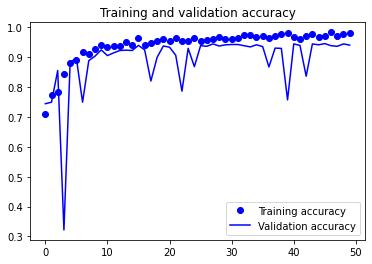

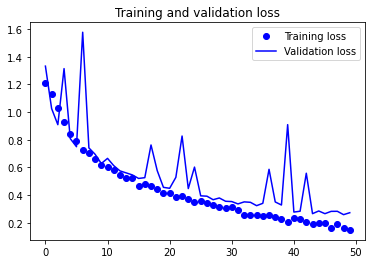

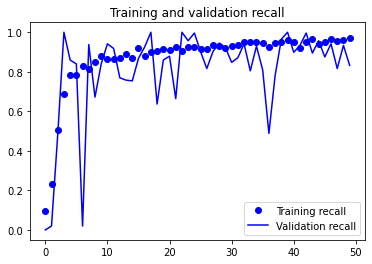

Mean Training Accuracy: 0.941019995212555
Mean Validation Accuracy: 0.8911600023508072

Mean Training Loss: 0.433892962038517
Mean Validation Loss: 0.5511878550052642

Mean Training Recall: 0.8703529469668865
Mean Validation Recall: 0.811953125

Training Evaluation:
32/32 [==============================] - 1s 12ms/step - loss: 0.1432 - accuracy: 0.9850 - recall: 0.9529

Validation Evaluation:
32/32 [==============================] - 0s 12ms/step - loss: 0.2721 - accuracy: 0.9400 - recall: 0.8320
Validation Confusion Matrix:

Training Confusion Matrix:


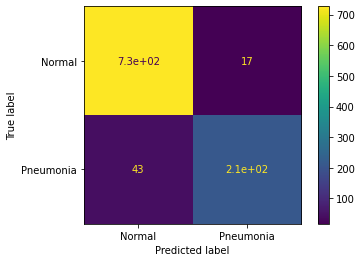

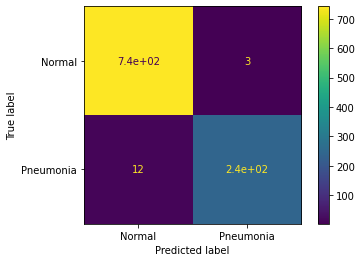

In [40]:
nn_model([32,16],batch_size=1000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 2s 15ms/step - loss: 1.2850 - accuracy: 0.7150 - recall: 0.0072 - val_loss: 1.1861 - val_accuracy: 0.7400 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 1s 11ms/step - loss: 1.1499 - accuracy: 0.7750 - recall: 0.2581 - val_loss: 1.0395 - val_accuracy: 0.8680 - val_recall: 0.7692
Epoch 3/50
100/100 [==============================] - 1s 11ms/step - loss: 1.0548 - accuracy: 0.8300 - recall: 0.5914 - val_loss: 0.9895 - val_accuracy: 0.8460 - val_recall: 0.4346
Epoch 4/50
100/100 [==============================] - 1s 11ms/step - loss: 0.9571 - accuracy: 0.8610 - recall: 0.7204 - val_loss: 0.8848 - val_accuracy: 0.8900 - val_recall: 0.7846
Epoch 5/50
100/100 [==============================] - 1s 10ms/step - loss: 0.8940 - accuracy: 0.8870 - recall: 0.7563 - val_loss: 1.4840 - val_accuracy: 0.6100 - val_recall: 0.9923
Epoch 6

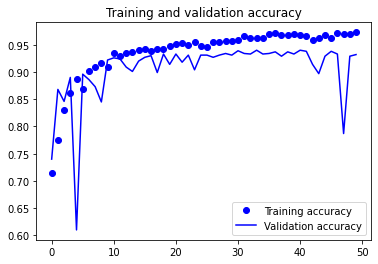

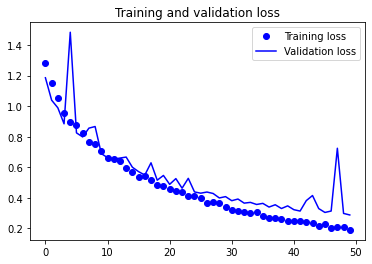

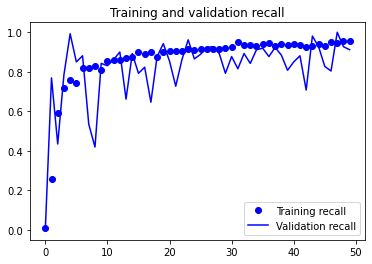

Mean Training Accuracy: 0.9363599991798401
Mean Validation Accuracy: 0.9063200044631958

Mean Training Loss: 0.48140747666358946
Mean Validation Loss: 0.5505496025085449

Mean Training Recall: 0.8609319016709924
Mean Validation Recall: 0.8198461568355561

Training Evaluation:
32/32 [==============================] - 1s 8ms/step - loss: 0.1641 - accuracy: 0.9830 - recall: 0.9857

Validation Evaluation:
32/32 [==============================] - 0s 9ms/step - loss: 0.2882 - accuracy: 0.9320 - recall: 0.9115
Validation Confusion Matrix:

Training Confusion Matrix:


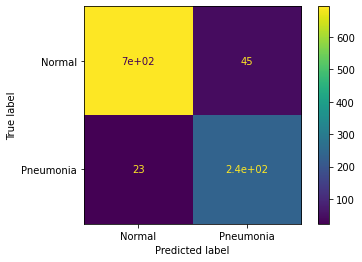

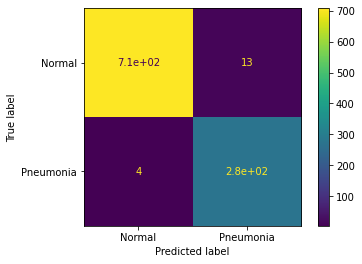

In [56]:
nn_model([32,16,8],batch_size=1000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 2s 14ms/step - loss: 1.3290 - accuracy: 0.7330 - recall: 0.0482 - val_loss: 1.2064 - val_accuracy: 0.7460 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 1s 10ms/step - loss: 1.1902 - accuracy: 0.7470 - recall: 0.2771 - val_loss: 1.2856 - val_accuracy: 0.7460 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 1s 11ms/step - loss: 1.1042 - accuracy: 0.7960 - recall: 0.5261 - val_loss: 1.0368 - val_accuracy: 0.7940 - val_recall: 0.1929
Epoch 4/50
100/100 [==============================] - 1s 10ms/step - loss: 1.0360 - accuracy: 0.8320 - recall: 0.6667 - val_loss: 0.9394 - val_accuracy: 0.8940 - val_recall: 0.6732
Epoch 5/50
100/100 [==============================] - 1s 11ms/step - loss: 0.9377 - accuracy: 0.8750 - recall: 0.7390 - val_loss: 1.0075 - val_accuracy: 0.8100 - val_recall: 0.9606
Epo

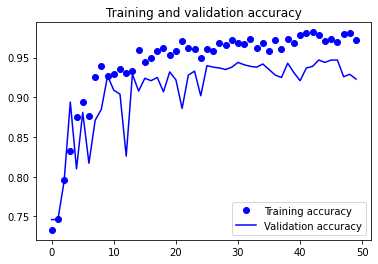

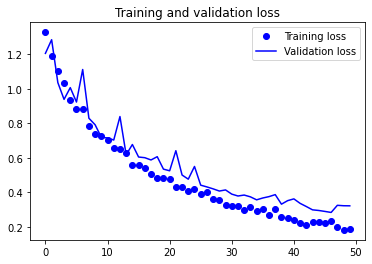

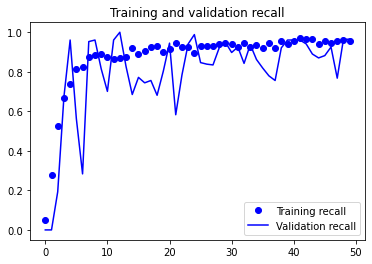

Mean Training Accuracy: 0.9414999997615814
Mean Validation Accuracy: 0.9088199996948242

Mean Training Loss: 0.489140242934227
Mean Validation Loss: 0.559912239909172

Mean Training Recall: 0.8745381492376327
Mean Validation Recall: 0.7957480359077453

Training Evaluation:
32/32 [==============================] - 1s 8ms/step - loss: 0.1971 - accuracy: 0.9720 - recall: 1.0000

Validation Evaluation:
32/32 [==============================] - 0s 8ms/step - loss: 0.3217 - accuracy: 0.9230 - recall: 0.9646
Validation Confusion Matrix:

Training Confusion Matrix:


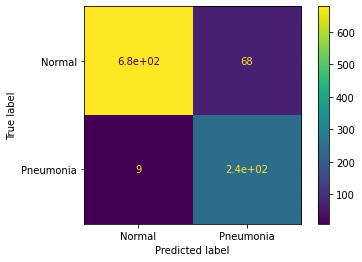

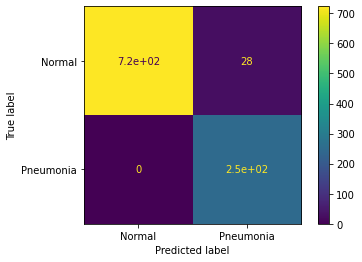

In [57]:
nn_model(dense_list=[32,16,10], batch_size=1000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 3s 14ms/step - loss: 0.9637 - accuracy: 0.7430 - recall: 0.0000e+00 - val_loss: 0.8945 - val_accuracy: 0.7450 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 1s 11ms/step - loss: 0.8527 - accuracy: 0.7420 - recall: 0.0039 - val_loss: 0.7824 - val_accuracy: 0.7450 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 1s 11ms/step - loss: 0.8141 - accuracy: 0.7710 - recall: 0.1673 - val_loss: 0.7930 - val_accuracy: 0.7450 - val_recall: 0.0000e+00
Epoch 4/50
100/100 [==============================] - 1s 11ms/step - loss: 0.7328 - accuracy: 0.8500 - recall: 0.6070 - val_loss: 0.7565 - val_accuracy: 0.8360 - val_recall: 0.3765
Epoch 5/50
100/100 [==============================] - 1s 11ms/step - loss: 0.6946 - accuracy: 0.8930 - recall: 0.7315 - val_loss: 0.6783 - val_accuracy: 0.8900 - val_recall: 0.

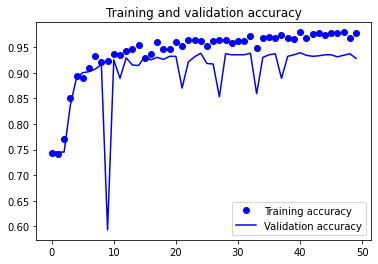

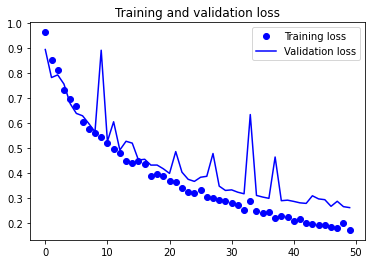

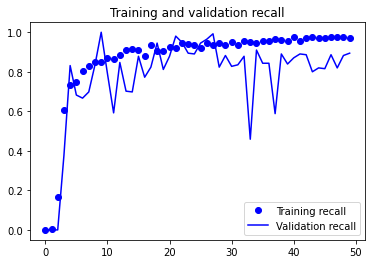

Mean Training Accuracy: 0.9402800011634826
Mean Validation Accuracy: 0.9022200000286102

Mean Training Loss: 0.3824781686067581
Mean Validation Loss: 0.4486551511287689

Mean Training Recall: 0.8630350145651028
Mean Validation Recall: 0.7726274597644806

Training Evaluation:
32/32 [==============================] - 1s 9ms/step - loss: 0.1633 - accuracy: 0.9840 - recall: 1.0000

Validation Evaluation:
32/32 [==============================] - 0s 9ms/step - loss: 0.2616 - accuracy: 0.9280 - recall: 0.8941
Validation Confusion Matrix:

Training Confusion Matrix:


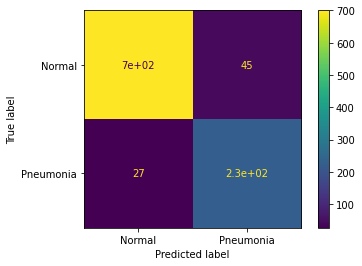

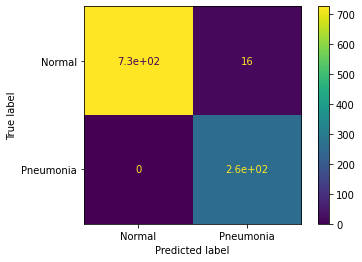

In [58]:
nn_model([16,8,4,2,2],batch_size=1000, ts_tuple=(512,512))

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 2s 15ms/step - loss: 0.7508 - accuracy: 0.7110 - recall: 0.1000 - val_loss: 0.7275 - val_accuracy: 0.7430 - val_recall: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 1s 11ms/step - loss: 0.7133 - accuracy: 0.7400 - recall: 0.0000e+00 - val_loss: 0.6990 - val_accuracy: 0.7430 - val_recall: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 1s 11ms/step - loss: 0.6910 - accuracy: 0.7400 - recall: 0.0000e+00 - val_loss: 0.6814 - val_accuracy: 0.7430 - val_recall: 0.0000e+00
Epoch 4/100
100/100 [==============================] - 1s 11ms/step - loss: 0.6772 - accuracy: 0.7400 - recall: 0.0000e+00 - val_loss: 0.6701 - val_accuracy: 0.7430 - val_recall: 0.0000e+00
Epoch 5/100
100/100 [==============================] - 1s 11ms/step - loss: 0.6683 - accuracy: 0.7400 - recall: 0.0000e+00 - val_loss: 0.6627 - val_accuracy: 0.

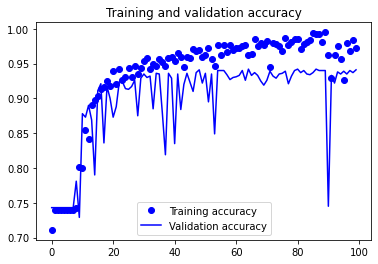

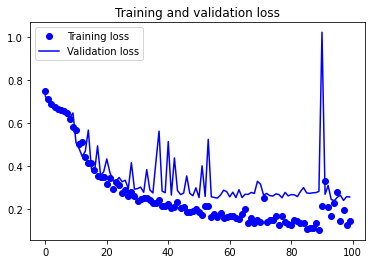

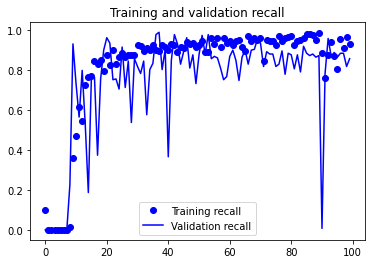

Mean Training Accuracy: 0.9341500002145767
Mean Validation Accuracy: 0.9000699979066848

Mean Training Loss: 0.2646965233236551
Mean Validation Loss: 0.3572836558520794

Mean Training Recall: 0.8126538441423327
Mean Validation Recall: 0.743929952676408

Training Evaluation:
32/32 [==============================] - 1s 8ms/step - loss: 0.1018 - accuracy: 0.9940 - recall: 0.9808

Validation Evaluation:
32/32 [==============================] - 0s 9ms/step - loss: 0.2555 - accuracy: 0.9410 - recall: 0.8560
Validation Confusion Matrix:

Training Confusion Matrix:


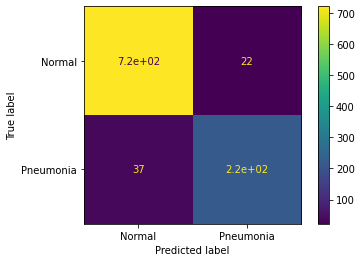

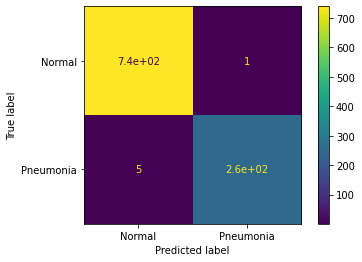

In [59]:
nn_model(dense_list=[32,16,8,4,2], input_nodes=64, batch_size=1000, ts_tuple=(256,256), l2_rate=0.001, epochs=100)

In [76]:
def cnn_preprocessing(train_directory=train_dir,
                      test_directory=test_dir,
                      ts_tuple=(256,256), 
                      color='grayscale', 
                      batch_size=None,
                      process_test=False):

    
    arg_dict = {'target_size':ts_tuple, 
                'color_mode':color, 
                'batch_size':batch_size}
    
    
    
    
    
    if process_test:
        
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

        train_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='training', class_mode='binary')
        
        val_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='validation', class_mode='binary', shuffle=False)
        
        test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict, class_mode='binary', shuffle=False)

        
        return train_generator, val_generator, test_generator
    
    
    else:
    
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
       
        train_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='training', class_mode='binary', ) 

        val_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='validation', class_mode='binary', shuffle=False)
    
    
    
    
        return train_generator, val_generator
    
   
    
    


In [107]:
def visualize_cnn_test(history, model, train_generator, val_generator, test_generator):
    

    
    
    acc = history.history['accuracy']
    mean_acc = np.mean(history.history['accuracy'])
    val_acc = history.history['val_accuracy']
    mean_val_acc = np.mean(history.history['val_accuracy'])
    
    loss = history.history['loss']
    mean_loss = np.mean(history.history['loss'])
    val_loss = history.history['val_loss']
    mean_val_loss = np.mean(history.history['val_loss'])
    
    recall = history.history['recall']
    mean_recall = np.mean(history.history['recall'])
    val_recall = history.history['val_recall']
    mean_val_recall = np.mean(history.history['val_recall'])

    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Test accuracy')
    plt.title('Training, and Test accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Test loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Training and Test recall')
    plt.legend()
    plt.show()
    
    
    #print(f'Mean Training Accuracy: {mean_acc}')
    #print(f'Mean Testing Accuracy: {mean_test_acc}')
    #print('')
    #print(f'Mean Training Loss: {mean_loss}')
    #print(f'Mean Testing Loss: {mean_test_loss}')
    #print('')
    #print(f'Mean Training Recall: {mean_recall}')
    #print(f'Mean Testing Recall: {mean_test_recall}')
    print('')
    print('Training Evaluation:')
    model.evaluate(train_generator)
    print('')
    print('Validation Evaluation:')
    model.evaluate(val_generator)
    print('')
    print('Testing Evaluation:')
    model.evaluate(test_generator)
                                   
    
    
    preds = (model.predict(test_generator) > 0.5).astype('int32')                
                
    
    cm = confusion_matrix(test_generator.classes, preds)
    

    cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    
    print('')
    print('Test Confusion Matrix')
    print('')
    
    cmd.plot();

In [108]:
def visualize_cnn(history, model, train_generator, val_generator):
    
    
    acc = history.history['accuracy']
    mean_acc = np.mean(history.history['accuracy'])
    val_acc = history.history['val_accuracy']
    mean_val_acc = np.mean(history.history['val_accuracy'])
    loss = history.history['loss']
    mean_loss = np.mean(history.history['loss'])
    val_loss = history.history['val_loss']
    mean_val_loss = np.mean(history.history['val_loss'])
    recall = history.history['recall']
    mean_recall = np.mean(history.history['recall'])
    val_recall = history.history['val_recall']
    mean_val_recall = np.mean(history.history['val_recall'])

    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()
    plt.show()
    
    
    #print(f'Mean Training Accuracy: {mean_acc}')
    #print(f'Mean Validation Accuracy: {mean_val_acc}')
    #print('')
    #print(f'Mean Training Loss: {mean_loss}')
    #print(f'Mean Validation Loss: {mean_val_loss}')
    #print('')
    #print(f'Mean Training Recall: {mean_recall}')
    #print(f'Mean Validation Recall: {mean_val_recall}')
    print('')
    print('Training Evaluation:')
    model.evaluate(train_generator)
    print('')
    print('Validation Evaluation:')
    model.evaluate(val_generator)
                                   
    
    
    
    preds = (model.predict(val_generator) > 0.5).astype('int32') 

    
    cm = confusion_matrix(val_generator.classes, preds)
    
      
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    
    print('')
    print('Validation Confusion Matrix')
    print('')
    
    cmd.plot()
    ;

In [109]:
def specific_cnn_model(filters=32,
              kernel_size=(3,3),
              conv_activation='relu',
              input_shape=(256,256,1),
              pool_size=(2,2),
              conv_kernel_size=(3,3),
              conv_layer_activation='relu',
              input_nodes=512,
              train_directory=train_dir,
              test_directory=test_dir,
              ts_tuple=(256,256), 
              color='grayscale',
              batch_size=50,
              process_test=False,
              input_activation='relu',
              layer_activation='relu',
              normal=False,
              output_activation='sigmoid',
              l2_rate=0.01,
              optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'],
              steps_per_epoch=60,
              epochs=20,
              bs=None,
              validation_steps=20,
              visualize=True):
    
    if not process_test:
        train_generator, val_generator = cnn_preprocessing(batch_size=batch_size)
    
    else:
        train_generator, val_generator, test_generator = cnn_preprocessing(batch_size=batch_size)
    
    print('ok')
    
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=conv_layer_activation,
                            input_shape=input_shape))
    cnn_model.add(layers.MaxPooling2D(pool_size))
    cnn_model.add(layers.Conv2D(64, (3, 3), activation=conv_layer_activation))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(128, (3, 3), activation=conv_layer_activation))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(128, (3, 3), activation=conv_layer_activation))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(units=input_nodes, activation=layer_activation))
    cnn_model.add(layers.Dense(1, activation=output_activation))

    cnn_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    print('ok')
    
    hist = cnn_model.fit(train_generator, 
                             steps_per_epoch=steps_per_epoch, 
                             epochs=epochs, 
                             batch_size=bs, 
                             validation_data=(val_generator),
                             validation_steps=validation_steps)
    
    
    if visualize:
    
        if process_test:
        
            visualize_cnn_test(hist, cnn_model, train_generator, test_generator)
         
        else:
        
            visualize_cnn(hist, cnn_model, train_generator, val_generator)
            
    else:
        
        pass

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
ok
ok
Epoch 1/5
60/60 [==============================] - 435s 7s/step - loss: 0.4640 - accuracy: 0.8085 - recall: 0.9368 - val_loss: 0.2900 - val_accuracy: 0.8850 - val_recall: 0.9836
Epoch 2/5
60/60 [==============================] - 422s 7s/step - loss: 0.1387 - accuracy: 0.9448 - recall: 0.9635 - val_loss: 0.1442 - val_accuracy: 0.9490 - val_recall: 0.9480
Epoch 3/5
60/60 [==============================] - 428s 7s/step - loss: 0.1207 - accuracy: 0.9528 - recall: 0.9663 - val_loss: 0.2166 - val_accuracy: 0.9190 - val_recall: 0.9918
Epoch 4/5
60/60 [==============================] - 409s 7s/step - loss: 0.1112 - accuracy: 0.9551 - recall: 0.9710 - val_loss: 0.1528 - val_accuracy: 0.9470 - val_recall: 0.9371
Epoch 5/5
60/60 [==============================] - 417s 7s/step - loss: 0.0854 - accuracy: 0.9633 - recall: 0.9736 - val_loss: 0.1223 - val_accuracy: 0.9550 - val_recall: 0.9754


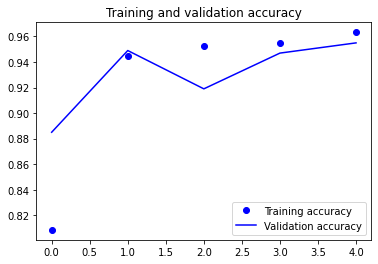

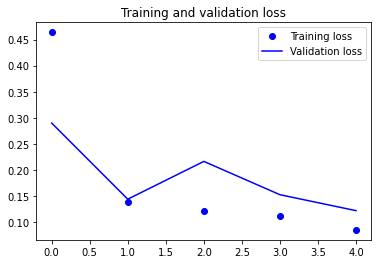

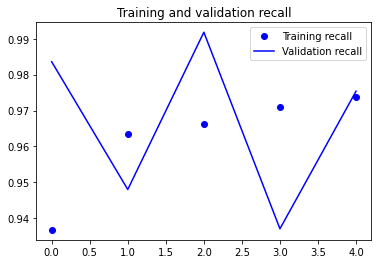

Mean Training Accuracy: 0.9249063611030579
Mean Validation Accuracy: 0.931000006198883

Mean Training Loss: 0.18399872332811357
Mean Validation Loss: 0.18519231379032136

Mean Training Recall: 0.9622417211532592
Mean Validation Recall: 0.9671682596206665

Training Evaluation:
84/84 [==============================] - 159s 2s/step - loss: 0.0690 - accuracy: 0.9744 - recall: 0.9887

Validation Evaluation:
21/21 [==============================] - 40s 2s/step - loss: 0.1170 - accuracy: 0.9569 - recall: 0.9768


NameError: ignored

In [28]:
specific_cnn_model(l2_rate=0.005, optimizer='adam', epochs=5)

In [113]:
def cnn_model(cnn_filters,
              filters=[128],
              dense_filters=[512],
              kernel_size=(3,3),
              conv_activation='relu',
              input_shape=(256,256,1),
              pool_size=(2,2),
              five_by_five=False,
              five_activation='relu',
              l2_rate=0.01,
              conv_normal=False,
              conv_kernel_size=(5,5),
              conv_layer_activation='relu',
              dense_activation='relu',
              dense_reg=False,
              normal=False,
              output_nodes=1,
              output_activation='sigmoid',
              optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'],
              steps_per_epoch=60,
              epochs=20,
              validation_steps=20,
              process_test=False,
              train_directory=train_dir,
              test_directory=test_dir,
              ts_tuple=(256,256), 
              color='grayscale',
              batch_size=50,
              visualize=True):
    
    
    if not process_test:
        train_generator, val_generator = cnn_preprocessing(batch_size=batch_size, process_test=process_test)
    
    
    else:
        train_generator, val_generator, test_generator = cnn_preprocessing(batch_size=batch_size, process_test=process_test)
    
    
    print('ok')
    
    
    cnn_model = models.Sequential()
    
    
    for i, val in enumerate(cnn_filters):
    
        cnn_model.add(layers.Conv2D(cnn_filters[i], kernel_size=kernel_size, activation=conv_activation,
                                input_shape=input_shape))
    
        cnn_model.add(MaxPooling2D(pool_size))
        
    
    if five_by_five:
    
        cnn_model.add(Conv2D(64, (5, 5), activation=five_activation, kernel_regularizer=l2(l2=l2_rate)))
    
    
    for i, val in enumerate(filters):
        
        if conv_normal:

            
            cnn_model.add(layers.MaxPooling2D(pool_size))
        
            cnn_model.add(layers.Conv2D(filters[i], kernel_size=conv_kernel_size, use_bias=False))
            
            cnn_model.add(layers.BatchNormalization())
            
            cnn_model.add(layers.Activation(conv_layer_activation))
            
            
        else:
            
            cnn_model.add(layers.MaxPooling2D(pool_size))
        
            cnn_model.add(layers.Conv2D(filters[i], kernel_size=conv_kernel_size, activation=conv_layer_activation))

    
    
    cnn_model.add(MaxPooling2D(pool_size))
    
    
    cnn_model.add(layers.Flatten())
    
    
    
    for ind, value in enumerate(dense_filters):
    
        
        if normal:
            
            cnn_model.add(layers.Dense(dense_filters[ind], use_bias=False, kernel_regularizer=l2(l2=l2_rate)))
            
            cnn_model.add(layers.BatchNormalization())
            
            cnn_model.add(Activation(dense_activation))
        
        
        else:
            
            if dense_reg:
            
                cnn_model.add(layers.Dense(dense_filters[ind], activation=dense_activation, kernel_regularizer=l2(l2=l2_rate)))
            
            else:
        
                cnn_model.add(layers.Dense(dense_filters[ind], activation=dense_activation))
            
    
    cnn_model.add(layers.Dense(output_nodes, activation=output_activation))

    
    cnn_model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=metrics)
    
    print('ok')
    
    cnn_class_weights = get_class_weights()
    
    hist = cnn_model.fit(train_generator, 
                         steps_per_epoch=steps_per_epoch, 
                         epochs=epochs,  
                         validation_data=(val_generator),
                         validation_steps=validation_steps,
                         class_weight=cnn_class_weights)
    
   
    if visualize:

        
        if process_test:
        
            visualize_cnn_test(hist, cnn_model, train_generator, val_generator, test_generator)
            
         
        else:
        
            visualize_cnn(hist, cnn_model, train_generator, val_generator)
            
    else:
        
        pass

    
    return cnn_model
    
    return hist  

    
 
    
    
    
    

In [28]:
opt = SGD(learning_rate=0.05)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
ok
ok
Epoch 1/20
50/50 [==============================] - 58s 1s/step - loss: 19.7974 - accuracy: 0.8873 - recall: 0.9219 - val_loss: 5.1558 - val_accuracy: 0.7400 - val_recall: 1.0000
Epoch 2/20
50/50 [==============================] - 53s 1s/step - loss: 1.8714 - accuracy: 0.9523 - recall: 0.9673 - val_loss: 2.6857 - val_accuracy: 0.7429 - val_recall: 1.0000
Epoch 3/20
50/50 [==============================] - 52s 1s/step - loss: 1.0283 - accuracy: 0.9578 - recall: 0.9747 - val_loss: 1.2312 - val_accuracy: 0.7600 - val_recall: 1.0000
Epoch 4/20
50/50 [==============================] - 53s 1s/step - loss: 0.9729 - accuracy: 0.9458 - recall: 0.9611 - val_loss: 4.6355 - val_accuracy: 0.7557 - val_recall: 1.0000
Epoch 5/20
50/50 [==============================] - 53s 1s/step - loss: 0.7760 - accuracy: 0.9636 - recall: 0.9787 - val_loss: 4.7093 - val_accuracy: 0.7457 - val_recall: 1.0000
Epoch 6/20
50/50 [=

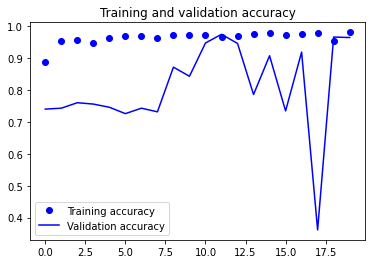

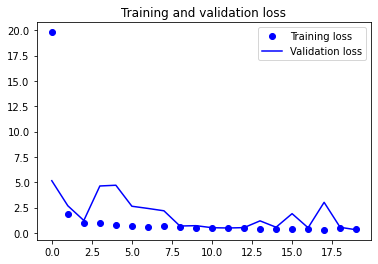

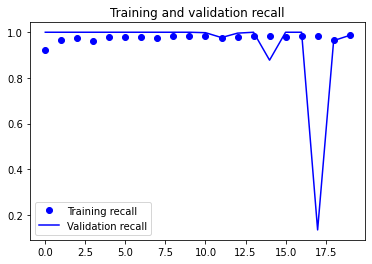

Mean Training Accuracy: 0.9637456357479095
Mean Validation Accuracy: 0.8081428557634354

Mean Training Loss: 1.5815805494785309
Mean Validation Loss: 1.835361796617508

Mean Training Recall: 0.9751124143600464
Mean Validation Recall: 0.9465871810913086

Training Evaluation:
60/60 [==============================] - 49s 818ms/step - loss: 0.2805 - accuracy: 0.9816 - recall: 0.9974

Validation Evaluation:
15/15 [==============================] - 13s 860ms/step - loss: 0.3164 - accuracy: 0.9636 - recall: 0.9884



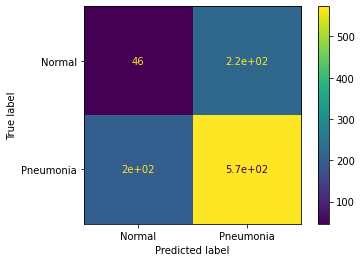

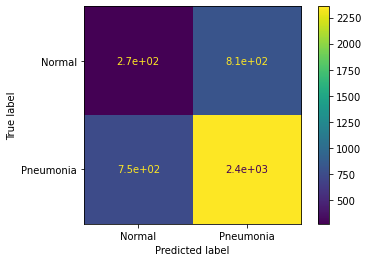

In [31]:
cnn_model(cnn_filters=[64,64,128], dense_list=[512,32], l2_rate=0.05, optimizer='adam', conv_normal=True, steps_per_epoch=50, batch_size=70, validation_steps=10)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
ok
ok
Epoch 1/20
50/50 [==============================] - 610s 12s/step - loss: 18.9360 - accuracy: 0.9397 - recall: 0.9461 - val_loss: 4.6951 - val_accuracy: 0.7198 - val_recall: 1.0000
Epoch 2/20
50/50 [==============================] - 802s 16s/step - loss: 2.2431 - accuracy: 0.9516 - recall: 0.9682 - val_loss: 1.5089 - val_accuracy: 0.7198 - val_recall: 1.0000
Epoch 3/20
50/50 [==============================] - 913s 18s/step - loss: 0.7828 - accuracy: 0.9579 - recall: 0.9703 - val_loss: 1.0839 - val_accuracy: 0.7198 - val_recall: 1.0000
Epoch 4/20
50/50 [==============================] - 906s 18s/step - loss: 0.6701 - accuracy: 0.9549 - recall: 0.9709 - val_loss: 1.1996 - val_accuracy: 0.7198 - val_recall: 1.0000
Epoch 5/20
50/50 [==============================] - 940s 19s/step - loss: 0.6183 - accuracy: 0.9552 - recall: 0.9701 - val_loss: 1.3137 - val_accuracy: 0.7198 - val_recall: 1.0000
Epoch 6/2

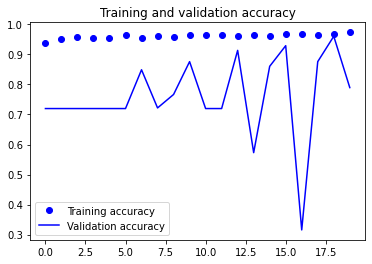

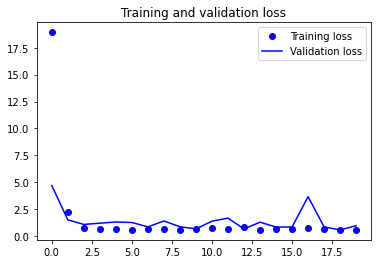

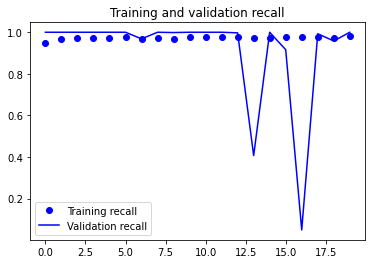

Mean Training Accuracy: 0.9614254087209702
Mean Validation Accuracy: 0.759479159116745

Mean Training Loss: 1.65656358897686
Mean Validation Loss: 1.3815916746854782

Mean Training Recall: 0.9723622560501098
Mean Validation Recall: 0.9143270596861839

Training Evaluation:
53/53 [==============================] - 96s 2s/step - loss: 0.9182 - accuracy: 0.8221 - recall: 0.9997

Validation Evaluation:
14/14 [==============================] - 21s 1s/step - loss: 0.9420 - accuracy: 0.8067 - recall: 1.0000


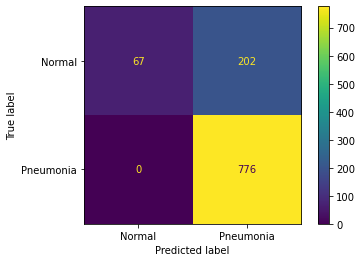

In [24]:
cnn_model(cnn_list=[64,128,128], dense_list=[512,256,32], l2_rate=0.05, optimizer='adam', conv_normal=True, normal=True, steps_per_epoch=50, batch_size=80, validation_steps=12)


In [81]:
cnn_model = cnn_model(cnn_filters=[32], five_by_five=True, conv_normal=True, process_test=True, steps_per_epoch=60, batch_size=50, validation_steps=20)


Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
ok
ok
Epoch 1/20
60/60 [==============================] - 394s 7s/step - loss: 2.1043 - accuracy: 0.8554 - recall: 0.9059 - val_loss: 0.7539 - val_accuracy: 0.7610 - val_recall: 0.9986
Epoch 2/20
60/60 [==============================] - 382s 6s/step - loss: 0.2783 - accuracy: 0.9431 - recall: 0.9601 - val_loss: 0.6413 - val_accuracy: 0.7660 - val_recall: 1.0000
Epoch 3/20
60/60 [==============================] - 373s 6s/step - loss: 0.1863 - accuracy: 0.9692 - recall: 0.9828 - val_loss: 0.5581 - val_accuracy: 0.9200 - val_recall: 0.9959
Epoch 4/20
60/60 [==============================] - 376s 6s/step - loss: 0.1406 - accuracy: 0.9833 - recall: 0.9910 - val_loss: 0.4807 - val_accuracy: 0.9610 - val_recall: 0.9562
Epoch 5/20
60/60 [==============================] - 378s 6s/step - loss: 0.1260 - accuracy: 0.9833 - recall: 0.9901 - val_loss: 0.3920 - val_accuracy: 0.

KeyError: 'test_recall'

In [87]:
cnn_model = cnn_model(cnn_filters=[32], five_by_five=True, conv_normal=True, process_test=True, epochs=15, steps_per_epoch=60, batch_size=50, validation_steps=20)


Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
ok
ok
Epoch 1/15
60/60 [==============================] - 417s 7s/step - loss: 2.0172 - accuracy: 0.8112 - recall: 0.9061 - val_loss: 0.8668 - val_accuracy: 0.6730 - val_recall: 0.5554
Epoch 2/15
60/60 [==============================] - 458s 8s/step - loss: 0.4009 - accuracy: 0.9063 - recall: 0.9421 - val_loss: 0.7068 - val_accuracy: 0.7310 - val_recall: 1.0000
Epoch 3/15
60/60 [==============================] - 413s 7s/step - loss: 0.2299 - accuracy: 0.9652 - recall: 0.9756 - val_loss: 0.5625 - val_accuracy: 0.8450 - val_recall: 1.0000
Epoch 4/15
60/60 [==============================] - 565s 9s/step - loss: 0.2054 - accuracy: 0.9673 - recall: 0.9771 - val_loss: 0.6099 - val_accuracy: 0.7310 - val_recall: 1.0000
Epoch 5/15
60/60 [==============================] - 812s 14s/step - loss: 0.1868 - accuracy: 0.9739 - recall: 0.9816 - val_loss: 0.4742 - val_accuracy: 0

KeyError: 'test_recall'

In [114]:
cnn_model = cnn_model(cnn_filters=[32], five_by_five=True, conv_normal=True, process_test=True, epochs=20, steps_per_epoch=60, batch_size=50, validation_steps=20)


Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
ok
ok
Epoch 1/20
 5/60 [=>............................] - ETA: 5:36 - loss: 26.5969 - accuracy: 0.5760 - recall: 0.6222

KeyboardInterrupt: 

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.fit(train_generator, 
                         steps_per_epoch=50, 
                         epochs=25, 
                         batch_size=10, 
                         validation_data=(val_generator),
                         validation_steps=20)